In [1]:
import torch 
# nn contains all of PyTorch's building blocks for neural network
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
print (torch.__version__)

2.9.0


In [ ]:
what_were_covering = {
    1: 'data preparing and loading',
    2:  'build model',
    3: 'fitting the model to data (training)',
    4: 'making predictions and evaluating a model (inference)',
    5: 'saving and loading a model',
    6: 'putting it all together'
}

# 1. Data Preparing and Loading

Data can be almost anything in machine learning

+ Excel Speadsheet

+ Images of any kind

+ Videos 

+ Audio like songs or podcasts

+ DNA

+ Text

In [21]:
weights = 0.7
bias = 0.3
start=0
end=1
step=0.02
X = torch.arange (start,end,step).unsqueeze(dim=1)
y = weights * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

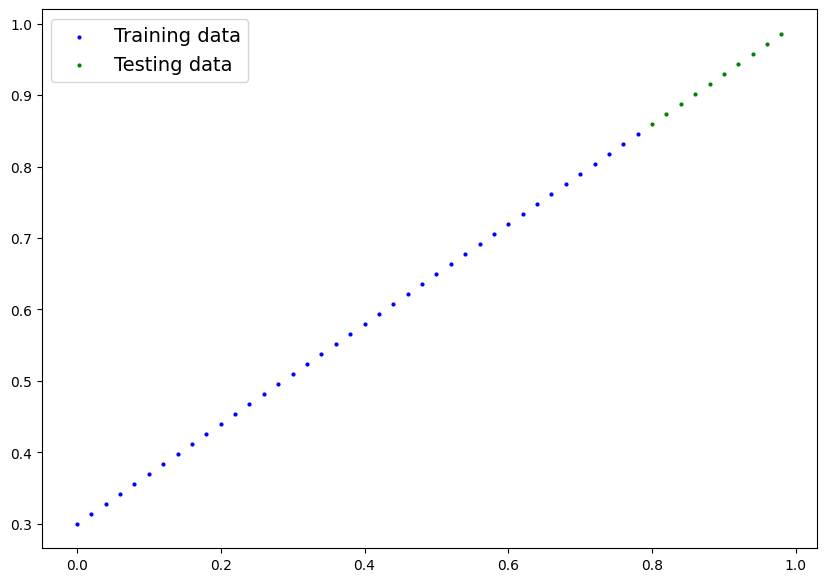

In [22]:
train_split = int (0.8 * len (X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  
  # Show the legend
  plt.legend(prop={"size": 14});

plot_predictions ()

# 2. Build models

+ torch.nn : contains all of the buildings for computational graph (a neural network can be considered a computational graph)

+ torch.nn.Parameter : what parameters should out model try and learn, often a PyTorch layer from torch.nn will set these for us

+ torch.nn.Module : the base class for all neural network modules, if you subclass it, you should overwrite forward ()

+ torch.optim : this is where the PyTorch live, they will help with gradient descent

+ def forward () : all nn.Module subclasses requires you to overwrite forward (), this method defines what happens in the forward computation

In [23]:
# Create linear regression model class
class LinearRegressionModel (nn.Module):
    def __init__ (self):
        super().__init__ ()
        self.weights = nn.Parameter (
            torch.randn (
                1, # start with a random weight and try to adjust it to the ideal weight
                requires_grad=True,
                dtype=torch.float
            )
        )
        self.bias = nn.Parameter (torch.randn (
            1, # start with a random bias and try to adjust it to the ideal bias
            requires_grad=True, 
            dtype=torch.float
        ))
        
    def forward (self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias
    # forward inherits from nn.Linear
    """
    def forward (self, input):
        return input @ self.weight.T + self.bias
    """
    
# --> This is the way that nn.Linear implements inside PyTorch

In [24]:
# Create a random seed
torch.manual_seed (42)

# Create an instance of the model (a subclass of nn.Module)
model_0 = LinearRegressionModel ()

# Check out the parameters
list (model_0.parameters ())

model_0.state_dict ()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [25]:
y_preds = model_0 (X_test) # = model_0.__call__ (X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [26]:
# Make predictions with model
with torch.inference_mode ():
    y_preds = model_0 (X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

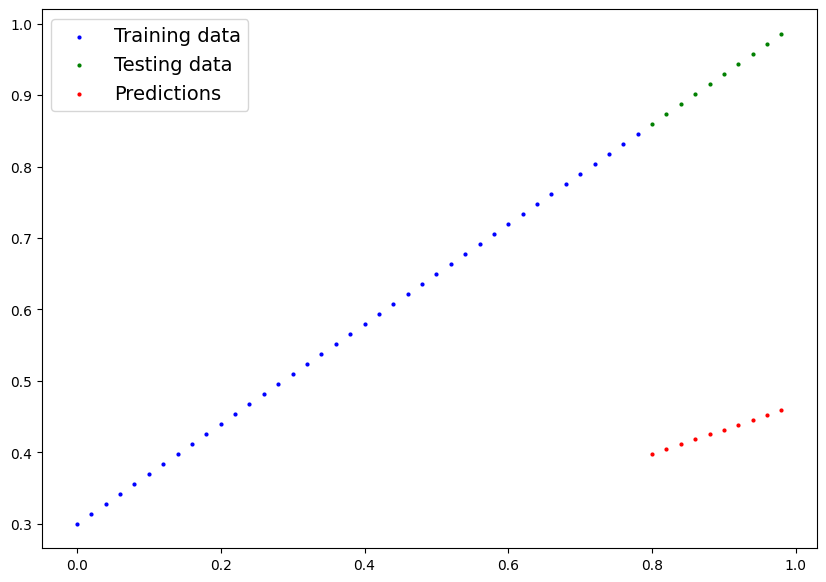

In [27]:
plot_predictions (predictions=y_preds)

# 3. Train model

Things we need to train:

+ **Loss function**: A function to measure how wrong your model's predictions are to the ideal outputs, lower is better

+ **Optimizer**: Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias) to improve the loss function

And specifically for PyTorch, we need:

+ A training loop

+ A testing loop

- Training mode: là model đang học --> Chạy vòng lặp :

+ loss.backward ()

+ optimizer.step ()

--> Mục tiêu: Cập nhật trọng số (weights) để giảm loss

--> Trong mode này, một số lớp hoạt động đặc biệt:

+ Dropout: ngẫu nhiên tắt một số neuron để tránh overfitting

+ BatchNorm: tính toán mean và variance từ batch hiện tại

- Inference mode: sau khi model được train xong, predict, không cập nhật weights, không tính gradient.

--> Một số lớp sẽ đổi hành vi:

+ Dropout: Tắt đi (không còn ngẫu nhiên)

+ BatchNorm: dùng mean và variance đã học được, không dùng batch hiện tại

In [28]:
loss_fn = nn.L1Loss () # Mean Absolute Error - MAE
"""
loss_fn = nn.MSELoss ()             # MSE
loss_fn = nn.SmoothL1Loss ()        # MSE & L1 (outliers)
loss_fn = nn.CrossEntropyLoss ()    # Cross-Entropy
loss_fn = nn.BCEWithLogitsLoss ()   # Binary Classification (output without sigmoid)
loss_fn = nn.BCELoss ()             # Binary Classification (output with sigmoid)
loss_fn = nn.NLLLoss ()             # Negative Log-Likelihood
loss_fn = nn.HuberLoss ()           # SmoothL1Loss
"""

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD (
    params=model_0.parameters (),
    lr=0.01
)

## Building a training loop (and a testing loop) in PyTorch

1. Forward pass (this involves data moving through our model's forward () function) to make predictions on data - also called **forward propagation**

2. Calculate the loss (compare forward pass predictions to ground truth label)

3. Optimizer zero gradient

4. Loss backward - move backwards through the network to calculate the gradients of each of parameters of our model with respect to the loss - **backpropagation**

5. Optimzer step - use the optimizer to adjust our model's parameter to try and improve the loss - **gradient descent**

In [31]:
torch.manual_seed (42)

# An epoch is one loop through the data (this is a hyperparameter because we've set it ourselves)
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data 
for epoch in range (epochs):
    # Set the model to training mode
    model_0.train () # train mode in PyTorch sets all parameters that require gradients to require gradients
    # 1. Forward pass
    y_pred = model_0 (X_train)
    
    # 2. Calculate the loss
    loss = loss_fn (y_pred, y_train)
    
    # 3.Optimizer zero grad
    optimizer.zero_grad ()
    
    # 4. Perform backpropagation on the loss respect to the parameters of the model (calculate gradients of each parameter)
    loss.backward ()
    
    # 5. Step the optimizer (perform gradient descent)
    optimizer.step () # by default how the optimizer changes will accumulate through the loop
    # --> we have to zero them above in step 3 for the next iteration of the loop
    
    ### Testing
    # turns off different settings in the model not needed for evaluation/testing (dropout / batch norm layers)
    model_0.eval ()
    with torch.inference_mode (): # turns off gradient tracking & a couple more things behind the scenes
    # with torch.no_grad (): 
        # 1. Do the forward pass
        test_pred = model_0 (X_test)
        
        # 2. Calculate the loss
        test_loss = loss_fn (test_pred, y_test)
        
    # Print out what's happening
    if epoch % 10 == 0:
        epoch_count.append (epoch)
        loss_values.append (loss)
        test_loss_values.append (test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        # Print out model state_dict()
        print(model_0.state_dict())

Epoch: 0 | Loss: 0.00893248151987791 | Test loss: 0.005023092031478882
OrderedDict({'weights': tensor([0.6951]), 'bias': tensor([0.2993])})
Epoch: 10 | Loss: 0.00893248151987791 | Test loss: 0.005023092031478882
OrderedDict({'weights': tensor([0.6951]), 'bias': tensor([0.2993])})
Epoch: 20 | Loss: 0.00893248151987791 | Test loss: 0.005023092031478882
OrderedDict({'weights': tensor([0.6951]), 'bias': tensor([0.2993])})
Epoch: 30 | Loss: 0.00893248151987791 | Test loss: 0.005023092031478882
OrderedDict({'weights': tensor([0.6951]), 'bias': tensor([0.2993])})
Epoch: 40 | Loss: 0.00893248151987791 | Test loss: 0.005023092031478882
OrderedDict({'weights': tensor([0.6951]), 'bias': tensor([0.2993])})
Epoch: 50 | Loss: 0.00893248151987791 | Test loss: 0.005023092031478882
OrderedDict({'weights': tensor([0.6951]), 'bias': tensor([0.2993])})
Epoch: 60 | Loss: 0.00893248151987791 | Test loss: 0.005023092031478882
OrderedDict({'weights': tensor([0.6951]), 'bias': tensor([0.2993])})
Epoch: 70 | Lo

In [32]:
np.array (torch.tensor (loss_values).numpy ()), test_loss_values

/var/folders/yr/p848yj_55kqbdt12_mktq1gw0000gn/T/ipykernel_92230/1008349135.py:1: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  np.array (torch.tensor (loss_values).numpy ()), test_loss_values


(array([0.00893248, 0.00893248, 0.00893248, 0.00893248, 0.00893248,
        0.00893248, 0.00893248, 0.00893248, 0.00893248, 0.00893248,
        0.00893248, 0.00893248, 0.00893248, 0.00893248, 0.00893248,
        0.00893248, 0.00893248, 0.00893248, 0.00893248, 0.00893248],
       dtype=float32),
 [tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050)])

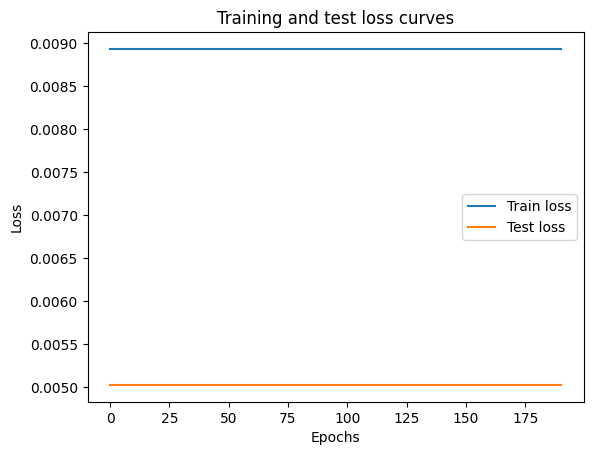

In [33]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

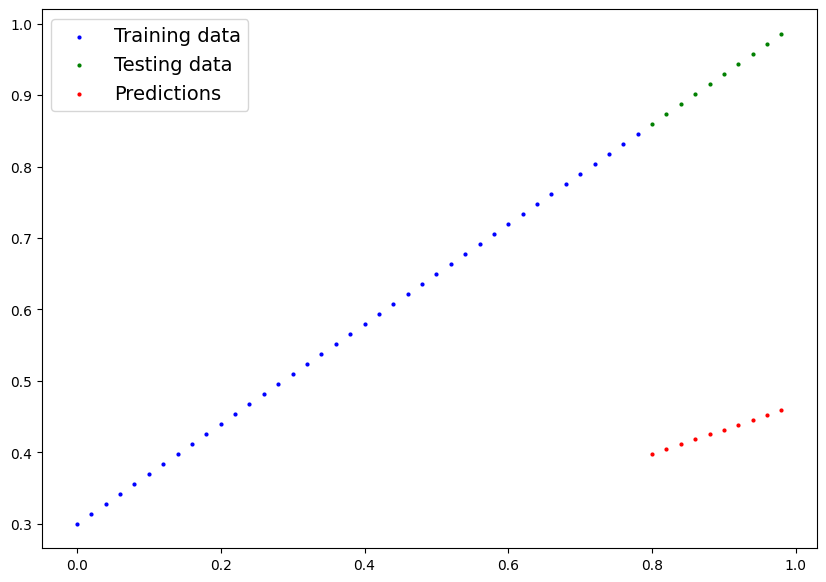

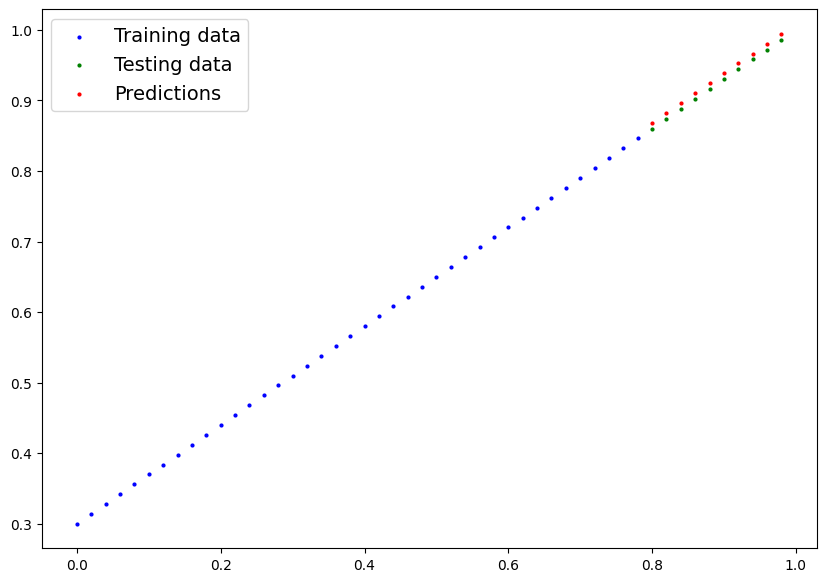

In [36]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)
  
plot_predictions(predictions=y_preds)

plot_predictions(predictions=y_preds_new);
model_0.state_dict ()

# 4. Saving a model in PyTorch

There are three main methods you should about for saving and loading models in PyTorch

1. torch.save () - save a PyTorch object in Python's pickle format

2. torch.load () - load a saved PyTorch object

3. torch.nn.Module.load_state_dict () - load a model's saved state dictionary

In [37]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path ("models")
MODEL_PATH.mkdir (parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '02_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 4. Save the model state dict 
print (f"Saving model to {MODEL_SAVE_PATH}")
torch.save (
    obj=model_0.state_dict (),
    f=MODEL_SAVE_PATH
)

Saving model to models/02_pytorch_workflow_model_0.pth


# 5. Loading a PyTorch model

In [38]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel ()
# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [40]:
loaded_model_0.state_dict()
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [41]:
# Make some models preds
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [42]:
# Compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6. Putting it all together